In [9]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import h5py
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical


In [10]:
home_path = os.path.expanduser('~')
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
working_path = os.path.join(parent_dir) #incase directory needs to be expanded
downloads_path = os.path.join(home_path, 'Downloads')
#extract_dir = os.path.expanduser("~\\Data_science")
extract_dir = os.path.join(home_path, 'Nextcloud/DataScientest/project/pcb')
root_dir = os.path.join(extract_dir, 'PCB_Defects_Detection')


In [11]:
# Set up folder paths
# Define the source paths for images and annotations
image_pool_path = os.path.join(extract_dir, 'VOC_PCB', 'JPEGImages')
annot_pool_path = os.path.join(extract_dir, 'VOC_PCB', 'Annotations')

# Define the destination path for images and annotations
image_dest_path = os.path.join(root_dir, 'data', 'Images')
annot_dest_path = os.path.join(root_dir, 'data', 'Annotations')

# Define the destination path for bboxes and masks
bb_path = os.path.join(working_path, 'data', 'Images_bb')
mask_path = os.path.join(working_path, 'data', 'Pixel_masks')

# Define the destination path for csv file
csv_path = os.path.join(root_dir, 'data', 'csv')

image_dataset_path = image_dest_path

In [12]:
#csv_bounding_boxes = (f'{csv_path}\\PCB_annotations_dataset.csv')
csv_bounding_boxes = os.path.join(csv_path, 'PCB_annotations_dataset.csv')
images = os.listdir(image_dataset_path)

In [13]:
df = pd.read_csv(csv_bounding_boxes, sep=";")

In [14]:
bounding_boxes_data = pd.read_csv(csv_bounding_boxes, sep=";")

image_data = []
class_labels = []
mask_data= []

grouped_bbox = bounding_boxes_data.groupby('filename')

In [15]:
image_data = []
mask_data = []
class_labels = []

for filename in images:
   
    image_path = os.path.join(image_dataset_path, filename)
    
    image = cv2.imread(image_path)
    image = cv2.resize(image, (600, 600))  
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_array = np.asarray(gray_image) / 255.0 
    image_data.append(image_array)

    filename = os.path.splitext(filename)[0]
        
    mask = np.zeros((600, 600), dtype=np.uint8)

    if filename in grouped_bbox.groups:
        image_bbox_df = grouped_bbox.get_group(filename)

        for index, row in image_bbox_df.iterrows():
            class_label = row['defect']
        
            xmin, ymin, xmax, ymax = [int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])] 
            #mask_color = class_to_color[class_label]
            mask[ymin:ymax, xmin:xmax] = 1 #mask_color 
    
        
    mask_data.append(mask)
    
    class_labels.append(class_label)

X_images = np.array(image_data)
y_bounding_boxes = np.array(mask_data)
y_class_labels = np.array(class_labels)

In [16]:
print(X_images.shape)
print(y_bounding_boxes.shape)
print(y_class_labels.shape)

(600, 600, 600)
(600, 600, 600)
(600,)


In [17]:
unique_labels, label_counts = np.unique(y_class_labels, return_counts=True)

for label, count in zip(unique_labels, label_counts):
    print(f"Label: {label}, Count: {count}")

Label: missing_hole, Count: 100
Label: mouse_bite, Count: 100
Label: open_circuit, Count: 100
Label: short, Count: 100
Label: spur, Count: 100
Label: spurious_copper, Count: 100


In [18]:
new_size = (100, 100)
threshold_none = 5
def crop_images(X_images, y_bounding_boxes, y_class_labels, new_size):
    if not all(new < orig and orig % new == 0 for orig, new in zip((600, 600), new_size)):
        print("New size must be smaller and a divisor of the original size.")
        return False
    
    cropped_images_int = []
    cropped_masks_int = []
    cropped_y_class_labels_int = []

    for image, mask, labels in zip(X_images, y_bounding_boxes, y_class_labels):
        for y in range(0, 600, new_size[0]):
            for x in range(0, 600, new_size[0]):
                y0, x0 = y, x
                y_new_size, x_new_size = y+new_size[0], x+new_size[0]
                # if a bounding box crosses the cropping border, shift the corresponding border, so defects are not cut off
                while( np.any(mask[y0, x0:x_new_size])) and (y0 != 0): 
                    y0 -= 1
                while (np.any(mask[min(y_new_size, 599), x0:x_new_size])) and (y_new_size != 600):
                    y_new_size += 1
                while( np.any(mask[y0:y_new_size, x0])) and (x0 != 0):
                    x0 -= 1
                while( np.any(mask[y0:y_new_size, min(x_new_size, 599)])) and (x_new_size != 600):
                    x_new_size += 1
                patch_image = cv2.resize(image[y0:y_new_size, x0:x_new_size], new_size)
                patch_mask = cv2.resize(mask[y0:y_new_size, x0:x_new_size], new_size)
                
                #patch_image = image[y:y+new_size[0], x:x+new_size[0]]
                #patch_mask = mask[y:y+new_size[0], x:x+new_size[0]]

                if np.sum(patch_mask) > threshold_none:
                    cropped_images_int.append(patch_image)
                    cropped_masks_int.append(patch_mask)
                    cropped_y_class_labels_int.append(labels)
                else:
                    cropped_images_int.append(patch_image)
                    cropped_masks_int.append(patch_mask)
                    cropped_y_class_labels_int.append("none")

    cropped_images = np.array(cropped_images_int)
    cropped_masks = np.array(cropped_masks_int)
    cropped_y_class_labels = np.array(cropped_y_class_labels_int)
    return cropped_images, cropped_masks, cropped_y_class_labels

cropped_images, cropped_masks, cropped_y_class_labels = crop_images(X_images, y_bounding_boxes, y_class_labels, new_size)

print(cropped_images.shape)
print(cropped_masks.shape)
print(cropped_y_class_labels.shape)

(21600, 100, 100)
(21600, 100, 100)
(21600,)


In [19]:
unique_labels, label_counts = np.unique(cropped_y_class_labels, return_counts=True)

for label, count in zip(unique_labels, label_counts):
    print(f"Label: {label}, Count: {count}")

Label: missing_hole, Count: 329
Label: mouse_bite, Count: 294
Label: none, Count: 19644
Label: open_circuit, Count: 292
Label: short, Count: 358
Label: spur, Count: 365
Label: spurious_copper, Count: 318


In [20]:
def plot_images(images, masks, labels, num_samples=6):
    _ , axes = plt.subplots(2, 3, figsize=(10, 6))
    axes = axes.ravel()
    sample_indices = np.random.choice(len(images), num_samples, replace=False)
    
    for i, idx in enumerate(sample_indices):
        axes[i].imshow(images[idx], cmap='gray')
        axes[i].imshow(masks[idx], alpha=0.5, cmap='jet')
        axes[i].set_title(f'Label: {labels[idx]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()



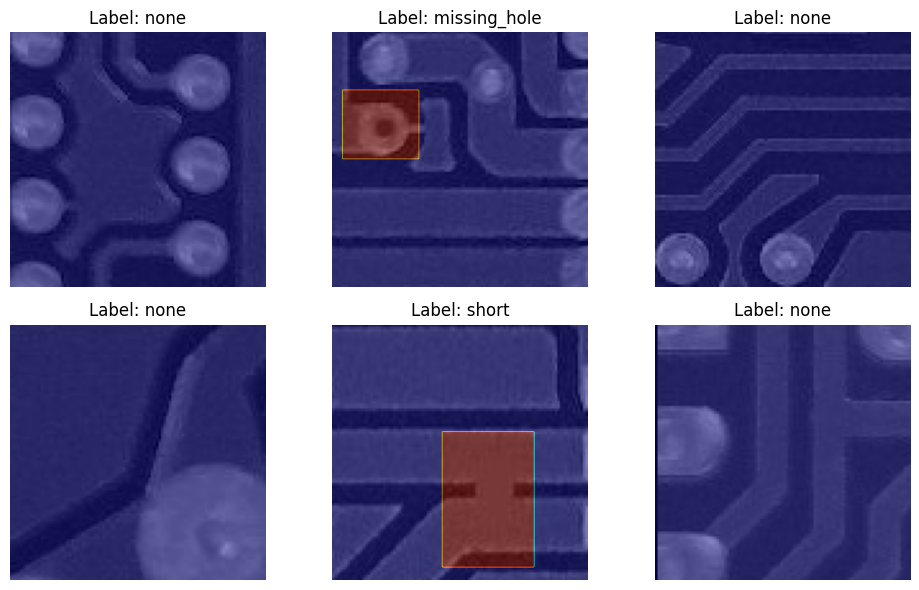

In [21]:
# Plot random 6 images
plot_images(cropped_images, cropped_masks, cropped_y_class_labels)

In [22]:

def separate_defects(original_images, mask_images, class_labels):
    separated_images = []
    separated_masks = []
    separated_labels = []

    for idx, (original_image, mask_image, class_label) in enumerate(zip(original_images, mask_images, class_labels)):
        contours, _ = cv2.findContours(mask_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # print(f"Processing Image {idx+1}")
        # print(f"Found {len(contours)} contours in image {idx+1}")
        if len(contours) > 1:
            #print(f"Image {idx+1}: Found {len(contours)} contours.")
            for _, contour in enumerate(contours):
                # print(f"Processing Contour {contour_idx+1} of {len(contours)}")
                all_contours_mask = np.zeros_like(mask_image)
                cv2.drawContours(all_contours_mask, [contour], -1, 255, -1)

                exclude_other_contours_mask = np.zeros_like(mask_image)
                cv2.drawContours(exclude_other_contours_mask, contours, -1, 255, -1)
                exclude_other_contours_mask = cv2.bitwise_xor(all_contours_mask, exclude_other_contours_mask)

                new_image = original_image.copy()
                new_mask = mask_image.copy()

                new_image[exclude_other_contours_mask == 255] = 0
                new_mask[exclude_other_contours_mask == 255] = 0

                separated_images.append(new_image)
                separated_masks.append(new_mask)
                separated_labels.append(class_label)

                '''
                # Debug print to confirm the processing of each contour
                print(f"Processed contour {contour_idx+1} for image {idx+1}")
                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(new_image, cmap='gray')
                plt.title(f"Image {idx+1} Contour {contour_idx+1}")
                plt.subplot(1, 2, 2)
                plt.imshow(new_mask, cmap='gray')
                plt.title(f"Mask {idx+1} Contour {contour_idx+1}")
                plt.show()
                '''

        else:
            separated_images.append(original_image.copy())
            separated_masks.append(mask_image.copy())
            separated_labels.append(class_label)
            # print(f"Image {idx+1} has {len(contours)} contours, appending original.")
                                        
    return separated_images, separated_masks, separated_labels

separated_images, separated_masks, separated_labels = separate_defects(cropped_images, cropped_masks, cropped_y_class_labels)


In [23]:
separated_images_array = np.asarray(separated_images)
separated_masks_array = np.asarray(separated_masks)
separated_labels_array = np.asarray(separated_labels)

print(separated_images_array.shape)
print(separated_masks_array.shape)
print(separated_labels_array.shape)

(21626, 100, 100)
(21626, 100, 100)
(21626,)


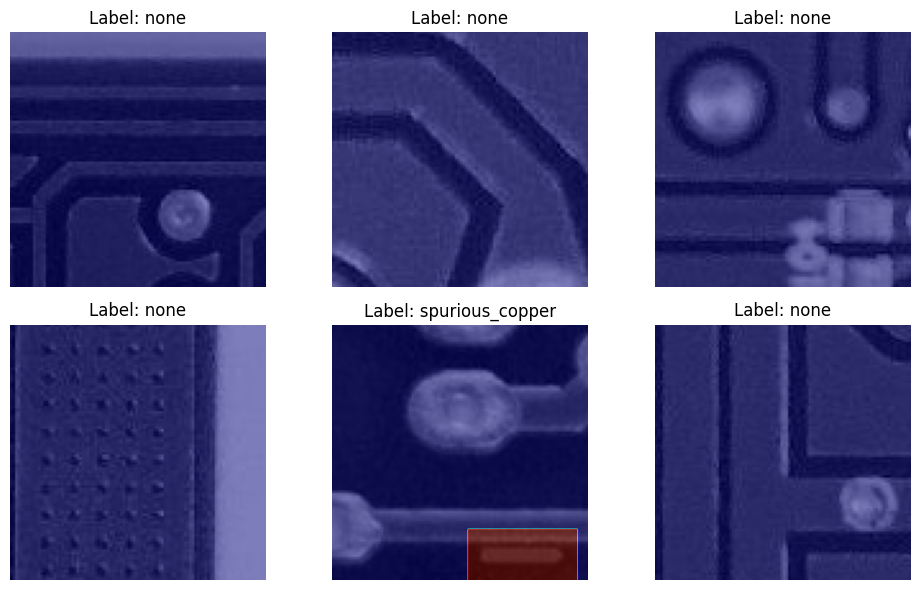

In [24]:
if separated_images:
    plot_images(separated_images_array, separated_masks_array, separated_labels_array)
else:
    print("No separated images found.")

In [25]:
unique_labels, label_counts = np.unique(separated_labels, return_counts=True)
label_count_dict = defaultdict(int)

for label, count in zip(unique_labels, label_counts):
    label_count_dict[label] = count
    print(f"Label: {label}, Count: {count}")

Label: missing_hole, Count: 332
Label: mouse_bite, Count: 295
Label: none, Count: 19644
Label: open_circuit, Count: 298
Label: short, Count: 361
Label: spur, Count: 369
Label: spurious_copper, Count: 327


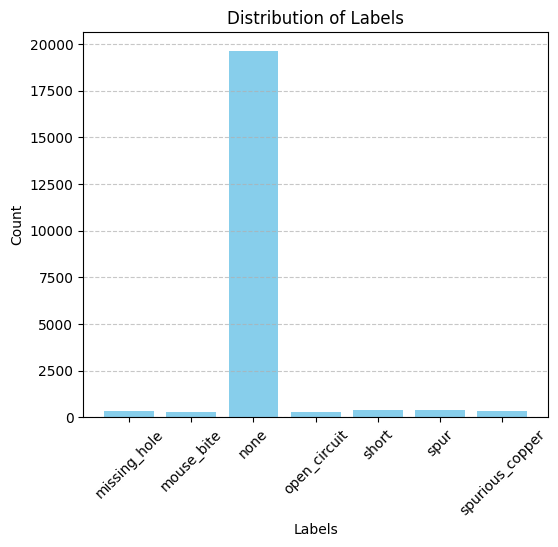

In [26]:
plt.figure(figsize=(6, 5))
plt.bar(unique_labels, label_counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The above distribution of data is clearly unbalanced, so we need to balance out the data by introducing more images to even out the distribution or to delete some data.

In [27]:
max_samples_per_class = min(label_counts)

In [28]:
# Filter out extra samples for each class label
filtered_images = []
filtered_masks = []
filtered_labels = []

for label in unique_labels:
    label_indices = [i for i, l in enumerate(separated_labels_array) if l == label]
    if label_count_dict[label] > max_samples_per_class:
        selected_indices = np.random.choice(label_indices, max_samples_per_class, replace=False)
    else:
        selected_indices = label_indices
    filtered_images.extend(separated_images_array[selected_indices])
    filtered_masks.extend(separated_masks_array[selected_indices])
    filtered_labels.extend(separated_labels_array[selected_indices])

# Convert the filtered lists to arrays
filtered_images = np.array(filtered_images)
filtered_masks = np.array(filtered_masks)
filtered_labels = np.array(filtered_labels)

In [29]:
# Print the shape of filtered data
print("Filtered Images Shape:", filtered_images.shape)
print("Filtered Masks Shape:", filtered_masks.shape)
print("Filtered Labels Shape:", filtered_labels.shape)

Filtered Images Shape: (2065, 100, 100)
Filtered Masks Shape: (2065, 100, 100)
Filtered Labels Shape: (2065,)


In [30]:
filtered_unique_labels, filtered_label_counts = np.unique(filtered_labels, return_counts=True)

label_count_dict = defaultdict(int)

for label, count in zip(filtered_unique_labels, filtered_label_counts):
    label_count_dict[label] = count
    print(f"Label: {label}, Count: {count}")

Label: missing_hole, Count: 295
Label: mouse_bite, Count: 295
Label: none, Count: 295
Label: open_circuit, Count: 295
Label: short, Count: 295
Label: spur, Count: 295
Label: spurious_copper, Count: 295


After including more images (along with the coresponding masks and labels) and deleting surplus data, the dataset is more balanced.

In [31]:
for i, label in enumerate(filtered_labels):
    # Check if the label is "none"
    if label == "none":
        # Replace the corresponding mask image with a blank image
        filtered_masks[i] = np.zeros_like(filtered_masks[i])

In [32]:
encoder = LabelEncoder()

y_class_labels_encoded = encoder.fit_transform(filtered_labels)
filtered_y_categorical = to_categorical(y_class_labels_encoded)

In [26]:
combined_data = []

combined_data = list(zip(filtered_images, filtered_masks, filtered_labels, filtered_y_categorical))

In [ ]:
np.random.seed = 666

picks = np.random.choice(range(filtered_labels.shape[0]), 10, replace=False)

for i in picks:
    fig, ax = plt.subplots(1, 2, figsize=(10,10))
    ax[0].imshow(filtered_images[i], cmap='gray')
    ax[1].imshow(filtered_masks[i], cmap='gray')
    ax[0].set_title(f'Label: {filtered_labels[i]}')
    ax[1].set_title(f'Categorical: {filtered_y_categorical[i]}')

In [28]:
print(filtered_images.shape)
print(filtered_masks.shape)
print(filtered_labels.shape)
print(filtered_y_categorical.shape)
print(filtered_label_counts.shape)

(2065, 100, 100)
(2065, 100, 100)
(2065,)
(2065, 7)
(7,)


In [29]:
# Split data into train and validation sets
X_train, X_test, y_train_mask, y_test_mask, y_train_class, y_test_class= train_test_split(filtered_images, filtered_masks, filtered_y_categorical, 
                                                                                                      test_size=0.2, random_state=666)

In [31]:
print("X_train shape:", X_train.shape)
print("y_train_mask shape:", y_train_mask.shape)
print("y_train_class shape:", y_train_class.shape)
print("X_test shape:", X_test.shape)
print("y_test_mask shape:", y_test_mask.shape)
print("y_test_class shape:", y_test_class.shape)

X_train shape: (1652, 100, 100)
y_train_mask shape: (1652, 100, 100)
y_train_class shape: (1652, 7)
X_test shape: (413, 100, 100)
y_test_mask shape: (413, 100, 100)
y_test_class shape: (413, 7)


In [32]:
# to save the filtered, augmented dataset to disk
def save_data_to_disk(X, y_mask, y_class, filepath):
    with h5py.File(filepath, 'w') as hf:
        hf.create_dataset('X', data=X)
        hf.create_dataset('y_mask', data=y_mask)
        hf.create_dataset('y_class', data=y_class)

In [33]:
file_name_train = "train_data.h5"
file_name_test = "test_data.h5"

file_path_train = os.path.join(downloads_path, file_name_train)
file_path_test = os.path.join(downloads_path, file_name_test)

save_data_to_disk(X_train, y_train_mask, y_train_class, file_path_train)
save_data_to_disk(X_test, y_test_mask, y_test_class, file_path_test)